# <center>**Distance Measurement Process**<center>

#### **Goal:** obtain a distance error between the misclassified hand drawn spirals and the ideal model of an archimedean spiral.

Any functions / processes that require the use of tensorflow or keras need to be in this file. Other functions can be in a seperate python file. 

## **Process**
1. Preprocess the data for preparation to run through CNN model (need training, validation, and testing)
    - If model already trained, only the testing data is needed for evaluation
2. Evaluate the test data on the trained model 
    - Save and plot the results
3. Create an ideal archimedean spiral model 
    - This will be used for calculating distance, and eventually error, between the patient's hand drawn spiral and the mathematical model of the spiral
    - Plot the ideal spiral overlayed with the test spirals, along with their classifications
    - Need to get the spiral one-pixel-width thick

**Note: The following steps will ONLY be performed on spirals misclassified by the CNN**

4. Calculate the locations of the centers of the test spirals (using objectDetection.ipynb)
5.  Process each test spiral so that it is one-pixel-width thick
    - Consider erosion and skeletonization for this, and also contours
6. Use the calculated locations of the center to unravel the spiral
    - Will also need to unravel the ideal spiral
7. Can then calculate the distance between the two and get an error measurement

*Instead of unravelling first, can also attempt to calculate the distance between the two spirals overlayed, but I think this is a more complicated approach if unravelling can be done*

*Can also consider contours to get a single pixel width - refer to ECE5554 contour homework example*


In [1]:
# import libraries
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # statistical data vis, used to plot the total count for each label
import os 
import wget
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import utils # used to shuffle data


from keras.preprocessing.image import ImageDataGenerator # used for image augmentation
import tensorflow as tf
# used for building and training a new model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
import object_detection

# image conversion and processing libraries
import cv2
import PIL
from PIL import Image

c:\Users\Rebecca\anaconda3\envs\MLEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# import functions from other python files
from code_files.imagePreprocessing import * 
from code_files.plottingFunctions import *
from code_files.archSpiral import *

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # disabling the GPU allows the model here to run

### Step 1: Preprocess the data (obtain training, validation, and testing data)

In [3]:
# import the images and create a dataframe containing the image path locations and their associated labels
dfTrain, dfVal, dfTest = importSetImages('datasets/spiral_data')

In [4]:
train_imgNames, trainLbl, val_imgNames, valLbl, test_imgNames, testLbl = dfTrain['images'], dfTrain['label'], dfVal['images'], dfVal['label'], dfTest['images'], dfTest['label']

In [5]:
# convert data into arrays and resize to size (128x128)
train, val, test = imgAug_preprocessing(train_imgNames, val_imgNames, test_imgNames)

**<center>NOTE: Only run the next code block if training a CNN model<center>**

In [7]:
# perform image augmentation if working on training a model (otherwise skip)
def imgAug(train_array, train_label, val_array, val_label, test_array, test_label):
    ## -------------------------------------------------------------------
    #       Artificially create more images for a bigger dataset
    ## -------------------------------------------------------------------
    # define functions to generate batches of data containing augmented images
    # use for training data only
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        fill_mode='nearest',
        brightness_range=[.4,1.4],
        vertical_flip = True,
        horizontal_flip = True
    )

    # use for validation and testing data (OPTIONAL: can make this different than training)
    test_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        fill_mode='nearest',
        brightness_range=[.4,1.4],
        vertical_flip = True,
        horizontal_flip = True
    )

    ## define function to artificially add more training, validation, and testing images
    # takes as inputs the dataset array, dataset labels, and the number of additional augmented images per each original image
    def generateAdditionalData(dataset_array, dataset_label, numImgs):
        dataAug = []
        dataAugLabel = []

        # iterate through each image in the data_array and create more images with the features specified by ImageDataGenerator
        for (idx,Lbl) in enumerate(dataset_label):
            tempImg = np.expand_dims(dataset_array[idx], axis=0) # use for grayscale
            # tempImg = train_array[idx]                         # use for rgb
            aug = train_gen.flow(tempImg, batch_size=1, shuffle=True)
            for addImages in range(numImgs):
                augImg = next(aug)[0] #.astype('uint8')
                if np.size(augImg) == 128**2:
                    dataAug.append(augImg)
                    dataAugLabel.append(Lbl)

        return dataAug, dataAugLabel

    trainAug, trainAugLabel = generateAdditionalData(train_array, train_label, 90)
    valAug, valAugLabel     = generateAdditionalData(val_array, val_label, 90)
    # testAug, testAugLabel   = generateAdditionalData(test_array, test_label, 90)

    # covert label array to binary class matrix (healthy, PD)
    trainAugLabel = tf.keras.utils.to_categorical(np.array(trainAugLabel))
    valAugLabel = tf.keras.utils.to_categorical(np.array(valAugLabel))
    # testAugLabel = tf.keras.utils.to_categorical(np.array(testAugLabel))

    # shuffle data one last time
    trainAug, trainAugLabel = utils.shuffle(trainAug, trainAugLabel)
    valAug, valAugLabel = utils.shuffle(valAug, valAugLabel)
    # testAug, testAugLabel = utils.shuffle(testAug, testAugLabel)

    return trainAug, trainAugLabel, valAug, valAugLabel #, testAug, testAugLabel

trainAug, trainLblAug, valAug, valLblAug = imgAug(train, trainLbl, val, valLbl, test, testLbl)

**<center> CNN Model Code <center>**

In [8]:
# ---------------------------------------------------------------------------------------
#                             BUILD AND TRAIN A NEW MODEL
# ---------------------------------------------------------------------------------------
reg = tf.keras.regularizers.l2(0.001)               # include a regularizer to help prevent overfitting
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)  # use the Adam optimizer and set an effective learning rate 

# build a model
model = Sequential([
    Conv2D(32, (3,3), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg, input_shape=(128,128,1)),
    MaxPool2D((3,3), strides=(1,1)),
    Conv2D(32, (3,3), padding='same', strides=(2,2), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(1,1)),
    Conv2D(64, (5,5), padding='same', strides=(1,1), dilation_rate = 2, activation='relu', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(2,2)),
    Conv2D(128, (7,7), padding='same', strides=(2,2), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(1,1)),
    Flatten(),

    ## include some fully connected layers
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2,activation='softmax') # softmax used for classification, sigmoid better for regression
])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(np.array(trainAug), trainLblAug, batch_size=128, epochs=35, validation_data=(np.array(valAug), valLblAug))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [9]:
modelName ='20220915'

# save model
savenameh5 = modelName + '.h5'
savenametf = modelName + '.tf'
model.save(savenameh5)
model.save(savenametf)

INFO:tensorflow:Assets written to: 20220915.tf\assets


INFO:tensorflow:Assets written to: 20220915.tf\assets


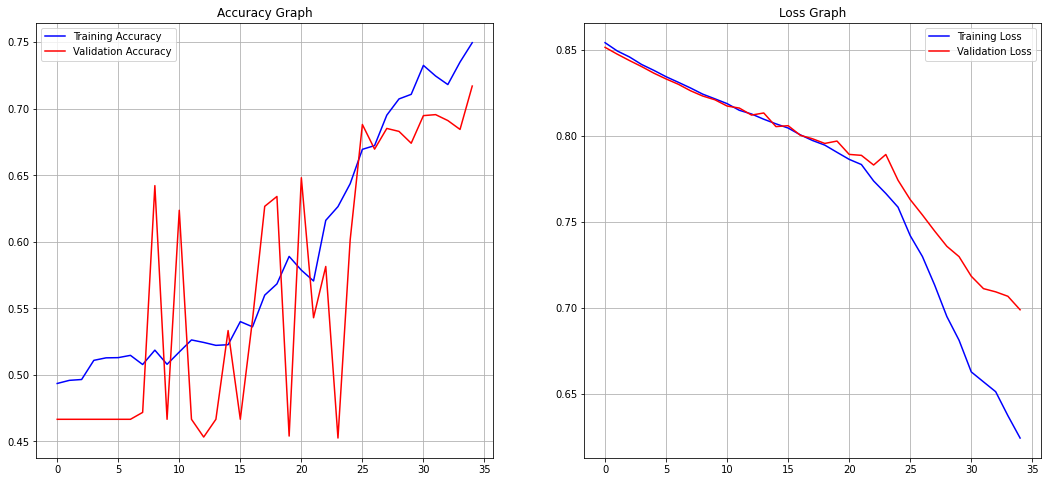

In [10]:
# -------------------------------------
# plot and save the results
# Accuracy and Validation Accuracy
accuracy1 = trained_model.history['accuracy']
val_acc1 = trained_model.history['val_accuracy']
epochs = range(len(accuracy1))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,8)
ax[0].plot(epochs, accuracy1, 'b', label='Training Accuracy')
ax[0].plot(epochs, val_acc1, 'r', label='Validation Accuracy')
ax[0].title.set_text('Accuracy Graph')
ax[0].legend()
ax[0].grid()

# Loss and Validation Loss
loss1 = trained_model.history['loss']
val_loss1 = trained_model.history['val_loss']

ax[1].plot(epochs, loss1, 'b', label='Training Loss')
ax[1].plot(epochs, val_loss1, 'r', label='Validation Loss')
ax[1].title.set_text('Loss Graph')
ax[1].legend()
ax[1].grid()

savefigName = modelName + '20220915_accuracy_loss_graph.png'
fig.savefig(savefigName)

### Step 2: Evaluate the test data on the trained model 

In [6]:
# ---------------------------------------------------------------------------------------
#                             LOAD PRE-EXISTING MODEL MODEL
# ---------------------------------------------------------------------------------------
def importModel(filename, testAug, testAugLabel):
    modelPath = 'savedModels/saved_h5_models/' + filename
    testModel = tf.keras.models.load_model(modelPath)

    loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=2)
    print("Loss: ", loss, "| Accuracy: ", acc)

    return testModel

In [7]:
# load existing model and evaluate the test data

# covert label array to binary class matrix (healthy, PD)
testLbl_categorical = tf.keras.utils.to_categorical(np.array(testLbl))
# test, testLbl = utils.shuffle(test, testLbl)
model = importModel('20220915.h5', test, testLbl_categorical)

1/1 - 0s - loss: 69.6214 - accuracy: 0.5625 - 451ms/epoch - 451ms/step
Loss:  69.62144470214844 | Accuracy:  0.5625


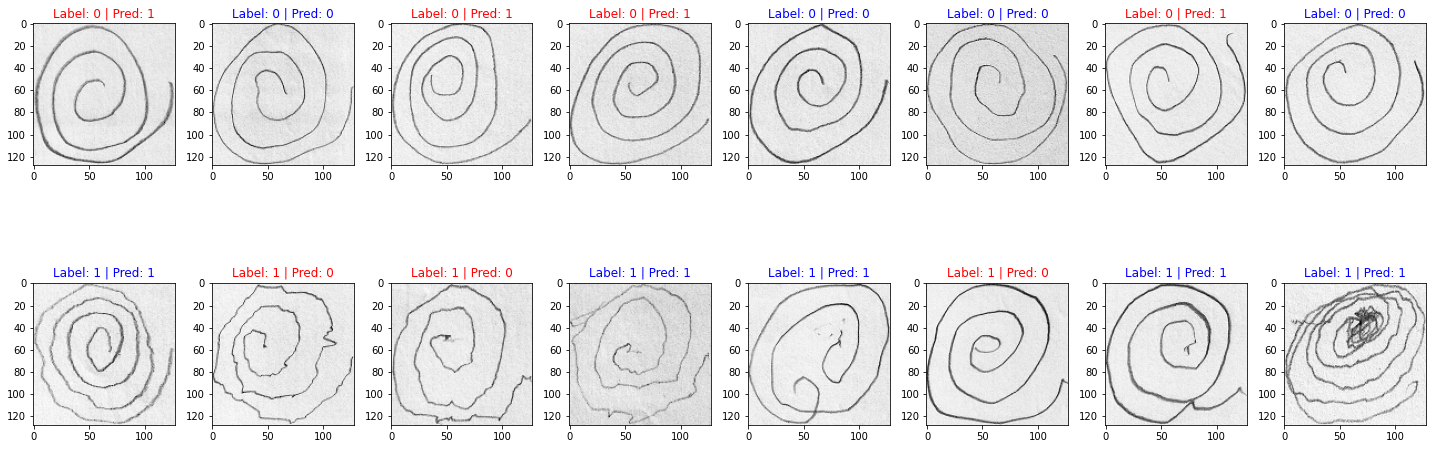

(7, 128, 128, 1)
[ 0  2  3  6  9 10 13]


In [8]:
# plot the results
misClass_test, misClass_idx = plotImages(model, test, testLbl)
print(np.shape(misClass_test))
print(misClass_idx)

### Step 3: Run through center detector model

#### <center>**Import model**<center>

In [10]:
# import needed libraries
import object_detection
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [11]:
# Define file locations
CHECKPOINT_PATH = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/git-repos/hand-tremor-detection/spiral-classifier/Tensorflow/workspace/models/my_ssd_mobnet/'
PIPELINE_CONFIG = CHECKPOINT_PATH + 'pipeline.config'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

#### <center>**Detect Center Points**<center>

In [48]:
LABEL_MAP = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/git-repos/hand-tremor-detection/spiral-classifier/Tensorflow/workspace/annotations/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP)

center_pts = []

# iterate through all the images and get the center locations with the bounding box
for i in range(len(misClass_test)):
    gray_img = cv2.resize(misClass_test[i], (256,256))
    image_np = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    # obtain the bounding box
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=1,
                min_score_thresh=.7,
                agnostic_mode=False)

    
    # cv2.imshow('img', cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    # cv2.waitKey()

    # find the center point coordinate, save it in an array
    bb = np.argmax(detections['detection_scores']).astype('int')
    ymin,xmin,ymax,xmax = detections['detection_boxes'][bb]*256
    ydiff = ymax-ymin
    xdiff = xmax-xmin

    ycenter = np.round(ymin + ydiff/2).astype('int')
    xcenter = np.round(xmin + xdiff/2).astype('int')
    
    center_pts.append([int(np.floor((xcenter) / 2)), int(np.floor((ycenter) / 2))])

print(center_pts)

[[64, 56], [64, 55], [125, 51], [57, 51], [47, 56], [64, 64], [64, 64]]


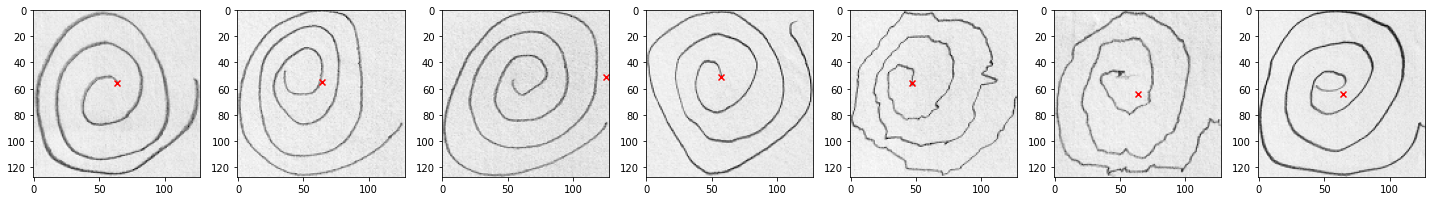

In [49]:
# plot the center points on the grayscale images
# plotCenters(misClass_test, center_pts)

from turtle import shape


cols = len(misClass_test)
rows = 1
count = 0
fig, axes = plt.subplots(rows, cols, figsize=(20,8))
axes = axes.flatten()
for img, ax in zip(misClass_test, axes):
    
    ax.imshow(np.squeeze(img), cmap="gray") # plot image
    ax.scatter(center_pts[count][0], center_pts[count][1], color='r', marker='x')
    count = count + 1
    
plt.tight_layout()
plt.show()

### Step 4: obtain one-pixel-width thick spirals

In [9]:
skelImgs = []

# skelImgs.append(skeletonize_imgs(idealSpiral))
for i in misClass_test:
    skelImgs.append(skeletonize_imgs(i))

plotSkelImgs(misClass_test, skelImgs)

### Step 5: Create the ideal archimedean spiral model

(128, 128)


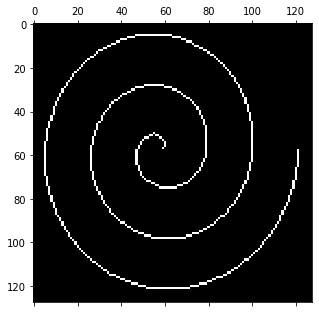

In [11]:
# create spiral
idealSpiral = generateIdealSpiral()
print(np.shape(idealSpiral))

# !! need to skeletonize !! then give it a try
idealSpiral = skeletonize_imgs(idealSpiral)

# plot
plt.figure(figsize=(5,5))
plt.matshow(idealSpiral, cmap='gray', fignum=1)

### Step 6: Unravel the spiral

In [13]:
# idealCenter = unravelSpiral(idealSpiral)
testCenter = unravelSpiral(skelImgs[0])

# distArrayIdeal = calcDist_to_center(idealSpiral, idealCenter)
distArrayTest = calcDist_to_center(skelImgs[0], testCenter)

## THIS METHOD DOESN'T WORK, CANT USE ARGWHERE
## NEED TO ITERATE AROUND THE SPIRAL AND CALCULATE IN THIS ORDER

Center Point:  [57 64]
Current RowCol:  [57, 64]
Current RowCol:  [56, 64]
Current RowCol:  [55, 63]
Current RowCol:  [54, 63]
Current RowCol:  [53, 62]
Current RowCol:  [52, 61]
Current RowCol:  [52, 60]
Current RowCol:  [51, 59]
Current RowCol:  [51, 58]
Current RowCol:  [51, 57]
Current RowCol:  [51, 56]
Current RowCol:  [51, 55]
Current RowCol:  [51, 54]
Current RowCol:  [51, 53]
Current RowCol:  [52, 52]
Current RowCol:  [52, 51]
Current RowCol:  [52, 50]
Current RowCol:  [52, 49]
Current RowCol:  [53, 48]
Current RowCol:  [54, 47]
Current RowCol:  [55, 46]
Current RowCol:  [56, 45]
Current RowCol:  [57, 44]
Current RowCol:  [58, 44]
Current RowCol:  [59, 43]
Current RowCol:  [60, 42]
Current RowCol:  [61, 41]
Current RowCol:  [62, 40]
Current RowCol:  [63, 40]
Current RowCol:  [64, 39]
Current RowCol:  [65, 39]
Current RowCol:  [66, 39]
Current RowCol:  [67, 39]
Current RowCol:  [68, 39]
Current RowCol:  [69, 38]
Current RowCol:  [70, 38]
Current RowCol:  [71, 38]
Current RowCol:

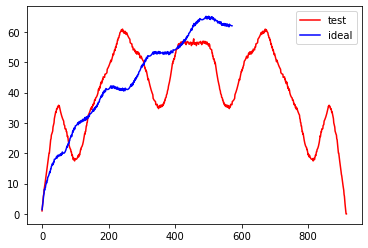

In [42]:
# ----------------------
# check which spiral is longer, and pad with None 
if len(distArrayIdeal) > len(distArrayTest):
    pad_width = len(distArrayIdeal) - len(distArrayTest)
    pad_array = np.ones(pad_width) * None
    distArrayTest.append(pad_array)
else:
    pad_width = len(distArrayTest) - len(distArrayIdeal)
    pad_array = pad_width * [None]
    distArrayIdeal = np.append(distArrayIdeal, pad_array)

    

# plot the result again the ideal spiral
xaxis = np.linspace(0, len(distArrayTest)-1, len(distArrayTest))
plt.plot(xaxis, distArrayTest, label="test", color='r')
plt.plot(xaxis, distArrayIdeal, label="ideal", color='b')
plt.legend()
plt.show()

In [ ]:
unraveledSpirals = np.array([])
for i in range(len(skelImgs)):
    flatSpiral = unravelSpiral(skelImgs[i])
    unraveledSpirals = np.vstack([unraveledSpirals, flatSpiral])

idealFlatSpiral = unravelSpiral(idealSpiral)


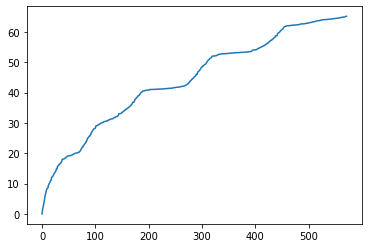

In [14]:
# plot
xaxis = np.linspace(0, len(distPts)-1, len(distPts))
plt.plot(xaxis, np.sort(distPts))

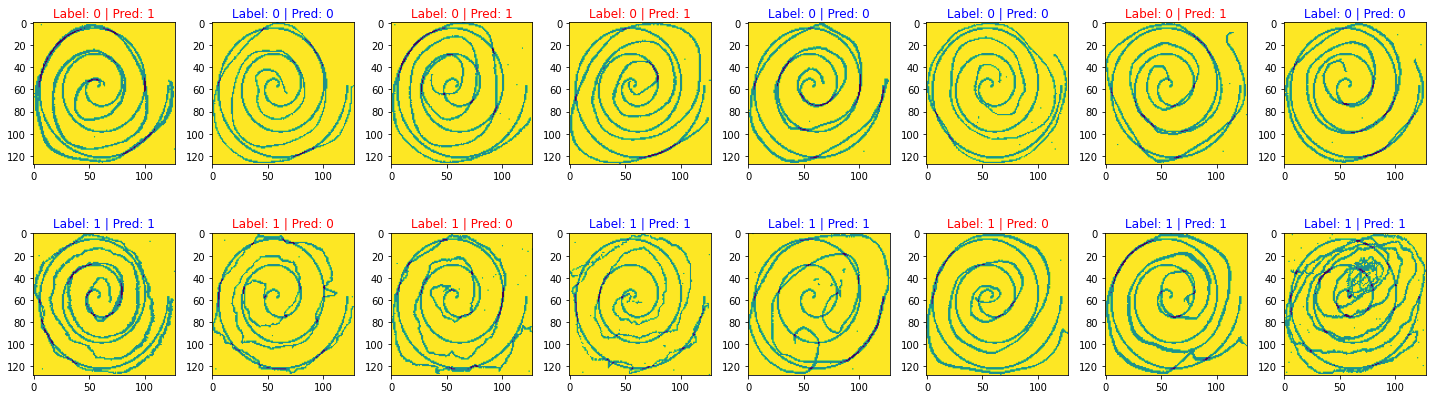

In [68]:
# plot the test spirals overlayed with ideal spiral
plotArchSpiralOverlay(test, testLbl, idealSpiral, model)

### Step 4: Calculate the locations of the centers of the spirals

Process:
- Train the model on the train and validation set generated
- Evaluate the model
- Detect center location from an image (use test data)
- Find the coordinates of the center point

In [9]:
# Need to split up the train and validation data into appropriate folders in ...Tensorflow/workspace/images
import shutil

outerDir = 'C:/Users/rebec/Documents/git-repos/hand-tremor-detection/hand-drawn-spiral-classifier-100patients/'
tfDir = outerDir + 'Tensorflow/workspace/images/'

# check if folder exists: 
trainPath = os.path.join(tfDir, 'train')
testPath = os.path.join(tfDir, 'test') # uses the validation images

os.mkdir(trainPath)
os.mkdir(testPath)

# move train images to train folder
for i in range(len(train_imgNames)):
    foldername = train_imgNames.iat[i]
    filename_png = os.path.basename(outerDir + foldername)
    filename_xml = filename_png.replace(".png", ".xml")
    shutil.copy(tfDir + filename_png, tfDir + 'train/' + filename_png)
    shutil.copy(tfDir + filename_xml, tfDir + 'train/' + filename_xml)

# move val images to test folder
for i in range(len(val_imgNames)):
    foldername = val_imgNames.iat[i]
    filename_png = os.path.basename(outerDir + foldername)
    filename_xml = filename_png.replace(".png", ".xml")
    shutil.copy(tfDir + filename_png, tfDir + 'test/' + filename_png)
    shutil.copy(tfDir + filename_xml, tfDir + 'test/' + filename_xml)
